In [1]:
import sys

from src.gauss_hist import get_gauss_stats

PWD = '../../..'
sys.path.append(PWD)

import numpy as np
import pandas as pd

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras import optimizers

from src.network_utils import count_params, plot_difference_hist, gaussian_kernel, dist_kernel, get_dist_root
from src.cross_validator import CrossValidator
from src.dataset import load_dataset_train_test, X_TIME, TIME_STEP
from src.models import optimal_model_builders_ch_2_11 as optimal_model_builders

In [2]:
PROJECT_NAME = 'compare'

PLANE = 2
CHANNEL = 11

OVERWRITE = False

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'
CROSSVAL_DIR = PWD + f'/data/model_selection/channel_{PLANE}_{CHANNEL}/cross_val'

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 4096

CROSSVAL_N_CV = 5
CROSSVAL_N_EXEC = 3
LOSS_WEIGHT_REGULAR = 1000
LOSS_WEIGHT_HEATMAP = 1000
LOSS_WEIGHT_DIST = 1000

In [3]:
X_base_train, _, y_base_train, _ = load_dataset_train_test(PWD, PLANE, CHANNEL)

X_base_train.shape

(22134, 24)

In [4]:
y_base_train_heatmap = np.array([gaussian_kernel(y) for y in y_base_train])
y_base_train_dist = np.array([dist_kernel(y) for y in y_base_train])

y_base_train_heatmap.shape, y_base_train_dist.shape

((22134, 24), (22134, 24))

In [5]:
def compile_wrapper(builder, loss_weight):
    def compiled_builder():
        model = builder()
        model.compile(loss='mse', optimizer=optimizers.Adam(LR), loss_weights=loss_weight)
        return model

    return compiled_builder

# Regular models

Number of parameters: 61153
Got score: 86.3385 (86.4755, 86.3276, 86.2126)
Got score: 84.7932 (84.8934, 84.8017, 84.6844)
Got score: 82.8655 (82.4802, 82.5065, 83.6098)
Got score: 82.9801 (83.4286, 82.8920, 82.6196)
Got score: 82.4768 (82.0065, 82.5830, 82.8410)


Number of parameters: 181153
Got score: 86.9550 (86.3548, 87.7171, 86.7932)
Got score: 85.1790 (85.1950, 85.2763, 85.0657)
Got score: 82.9660 (83.0034, 82.8632, 83.0314)
Got score: 82.8411 (83.0129, 82.5452, 82.9653)
Got score: 83.2567 (83.2054, 83.6411, 82.9237)


Number of parameters: 149601
Got score: 85.9491 (86.0664, 85.8471, 85.9338)
Got score: 84.6359 (84.8095, 84.3849, 84.7134)
Got score: 83.9128 (83.9502, 83.7036, 84.0845)
Got score: 82.7595 (82.6841, 82.6653, 82.9291)
Got score: 82.5381 (82.5944, 82.4332, 82.5867)


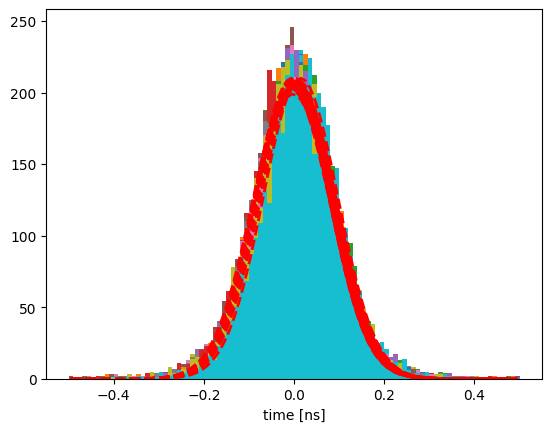

In [6]:
def regular_metric(y_true, y_pred):
    std, _, _ = plot_difference_hist(y_true, y_pred[:, 0], show=False, close=False)
    return std * 1000  # ps


regular_model_builders = [
    compile_wrapper(optimal_model_builders.mlp, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.convnet, loss_weight=LOSS_WEIGHT_REGULAR),
    compile_wrapper(optimal_model_builders.rnn, loss_weight=LOSS_WEIGHT_REGULAR),
]
regular_model_names = ['mlp', 'convnet', 'rnn']

cross_validator = CrossValidator(regular_model_builders, X_base_train, y_base_train, CROSSVAL_DIR, PROJECT_NAME,
                                 n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
                                 n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC, model_names=regular_model_names,
                                 eval_metric=regular_metric, overwrite=OVERWRITE)

regular_model_scores = cross_validator()

# Heatmap-based models

In [7]:
def heatmap_metric(y_heatmap_true, y_heatmap_pred):
    y_true = np.empty(y_heatmap_true.shape[0])
    for i, y in enumerate(y_heatmap_true):
        _, y_true[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    y_pred = np.empty(y_heatmap_pred.shape[0])
    for i, y in enumerate(y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    std, _, _ = plot_difference_hist(y_true, y_pred, show=False, close=False)
    return std * 1000  # ps


heatmap_model_builders = [compile_wrapper(optimal_model_builders.unet, loss_weight=LOSS_WEIGHT_HEATMAP)]
heatmap_model_names = ['unet']

cross_validator = CrossValidator(heatmap_model_builders, X_base_train, y_base_train_heatmap, CROSSVAL_DIR, PROJECT_NAME,
                                 n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
                                 n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC, model_names=heatmap_model_names,
                                 eval_metric=heatmap_metric, overwrite=OVERWRITE)

heatmap_model_scores = cross_validator()

Number of parameters: 1039969
Got score: 85.5103 (85.5910, 85.2978, 85.6421)
Got score: 84.1440 (84.3207, 83.6235, 84.4878)
Got score: 82.2769 (81.9731, 82.3207, 82.5370)
Got score: 81.9475 (81.5803, 81.9772, 82.2850)
Got score: 82.4335 (82.3956, 82.6509, 82.2541)


# Dist-based models

In [8]:
# def dist_metric(y_dist_true, y_dist_pred):
#     y_true = np.empty(y_dist_true.shape[0])
#     for i, y in enumerate(y_dist_true):
#         y_true[i] = get_dist_root(y)
#
#     y_pred = np.empty(y_dist_pred.shape[0])
#     for i, y in enumerate(y_dist_pred):
#         y_pred[i] = get_dist_root(y)
#
#     std, _, _ = plot_difference_hist(y_true, y_pred, show=False, close=False)
#     return std * 1000  # ps
#
#
# dist_model_builders = [compile_wrapper(optimal_model_builders.unet_dist, loss_weight=LOSS_WEIGHT_DIST)]
# dist_model_names = ['unet_dist']
#
# cross_validator = CrossValidator(dist_model_builders, X_base_train, y_base_train_dist, CROSSVAL_DIR, PROJECT_NAME,
#                                  n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, es_min_delta=ES_MIN_DELTA,
#                                  n_cv=CROSSVAL_N_CV, n_executions=CROSSVAL_N_EXEC, model_names=dist_model_names,
#                                  eval_metric=dist_metric, overwrite=OVERWRITE)
#
# dist_model_scores = cross_validator()

# Comparison

In [9]:
all_model_builders = regular_model_builders + heatmap_model_builders #+ dist_model_builders
all_model_names = regular_model_names + heatmap_model_names #+ dist_model_names
all_model_scores = regular_model_scores | heatmap_model_scores #| dist_model_scores

In [10]:
mean_scores = [f"{np.mean(scores):0.2f}" for scores in all_model_scores.values()]
std_scores = [f"{np.std(scores):0.2f}" for scores in all_model_scores.values()]
n_params = [count_params(builder()) for builder in all_model_builders]

df = pd.DataFrame({'mean': mean_scores, 'std': std_scores, 'n_params': n_params}, index=all_model_scores.keys())
df.index.name = 'Model'
df

,mean,std,n_params
Model,,,
mlp,83.89,1.46,61153
convnet,84.24,1.60,181153
rnn,83.96,1.26,149601
unet,83.26,1.36,1039969
